# Mapping between Seismic Stations and Boreholes

This notebook finds an estimate of sedimentary thickness at each seismic station using the boreholes in the station's vicinity.

In [1]:
import geopandas as gpd
import rf
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LinearSegmentedColormap, to_rgb
from shapely import Point
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import pygmt

from utils import get_australian_sedimentary_basins, get_geological_timeline, australia_basemap

Load RF data

In [2]:
dataroot = os.path.join("..", "data", "processed")
run = max(
    [
        os.path.join(dataroot, d)
        for d in os.listdir(dataroot)
        if os.path.isdir(os.path.join(dataroot, d))
    ],
    key=os.path.getmtime,
)
stacks = rf.read_rf(os.path.join(run, "rfstacks.h5"), format='h5').sort(["delay","network", "station"])
autos = rf.read_rf(os.path.join(run, "autostacks.h5"), format='h5')

Make geodataframe with relevant seismic data

In [3]:
stations = []
points = []
tpsbs = []
twtts = []
for tr in stacks:
    stations.append(".".join([tr.stats.network, tr.stats.station]))
    points.append(Point(tr.stats.station_longitude, tr.stats.station_latitude))
    tpsbs.append(tr.stats.delay)

    net = tr.stats.network
    sta = tr.stats.station
    try:
        auto = autos.select(network=net, station=sta)[0]
        twtts.append(auto.stats.twtt)
    except IndexError:
        twtts.append(np.nan)

seismics = gpd.GeoDataFrame(
    data={
        "stations": stations,
        "delays": tpsbs,
        "traveltimes": twtts,
        "geometry": points,
    }
)
seismics.set_index("stations", inplace=True)

Load boreholedata

In [4]:
dataroot = os.path.join("..", "data", "ABSUC")
boreholes = gpd.read_file(os.path.join(dataroot, "boreholes.geojson"))

Investigate borehole counts within certain ranges from seismic stations

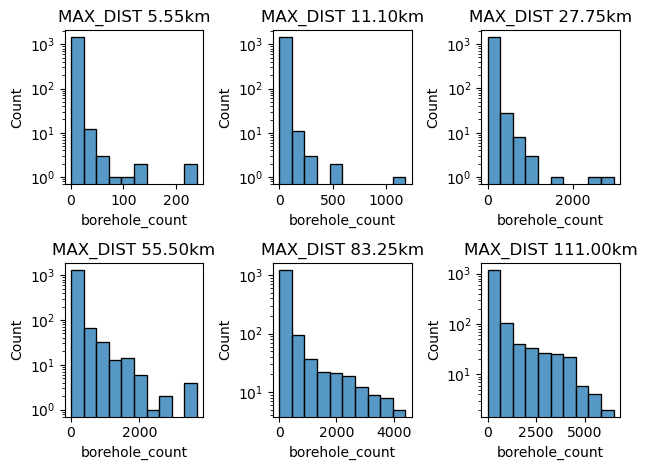

In [5]:
geo = Geodesic()  # returns distances in meters
bh_array = np.array([boreholes.geometry.x, boreholes.geometry.y]).T

fig, axs = plt.subplots(2, 3, tight_layout=True)
for ax, max_dist in zip(axs.flatten(), [0.05, 0.1, 0.25, 0.5, 0.75, 1]): # degrees
    max_dist *= 111  # km

    # define binning
    rbins = np.linspace(0, max_dist, 20)
    abins = np.linspace(0, 2 * np.pi, 36)
    R, A = np.meshgrid(rbins, abins)


    def build_hist(point):
        inv = geo.inverse([point.x, point.y], bh_array)
        inv[:, 0] /= 1000  # m -> km
        dists = inv[inv[:, 0] <= max_dist, 0]
        azs = inv[inv[:, 0] <= max_dist, 1] + 180  # range 0-360
        # calculate histogram
        hist, _, _ = np.histogram2d(dists, np.radians(azs), bins=(rbins, abins))
        return hist


    seismics["histograms"] = Parallel(n_jobs=-1)(
        delayed(build_hist)(p1) for p1 in seismics.geometry
    )
    seismics["borehole_count"] = seismics.histograms.apply(lambda x: int(x.sum()))

    sns.histplot(seismics, x="borehole_count", ax=ax, bins=10)
    ax.set_title(f"MAX_DIST {max_dist:.2f}km")
    ax.set_yscale("log")

In [6]:

def get_closest_borehole_distance(station):
    inv = geo.inverse([station.x, station.y], bh_array)
    dists = inv[:, 0] / 1000  # m -> km
    return dists.min()


seismics["closest_borehole_distance"] = np.array(
    Parallel(n_jobs=-1)(
        delayed(get_closest_borehole_distance)(p) for p in seismics.geometry
    )
)

Choose maximum distance and plot polar histograms

In [7]:
max_dist = 0.25  # degrees
max_dist *= 111 # km

# define binning
rbins = np.linspace(0, max_dist, 20)
abins = np.linspace(0, 2 * np.pi, 36)
R, A = np.meshgrid(rbins, abins)


def build_hist(point):
    inv = geo.inverse([point.x, point.y], bh_array)
    inv[:, 0] /= 1000  # m -> km
    dists = inv[inv[:, 0] <= max_dist, 0]
    azs = inv[inv[:, 0] <= max_dist, 1] + 180  # range 0-360
    # calculate histogram
    hist, _, _ = np.histogram2d(dists, np.radians(azs), bins=(rbins, abins))
    return hist


seismics["histograms"] = Parallel(n_jobs=-1)(
    delayed(build_hist)(p1) for p1 in seismics.geometry
)
seismics["borehole_count"] = seismics.histograms.apply(lambda x: int(x.sum()))


Polar histogram of borehole counts

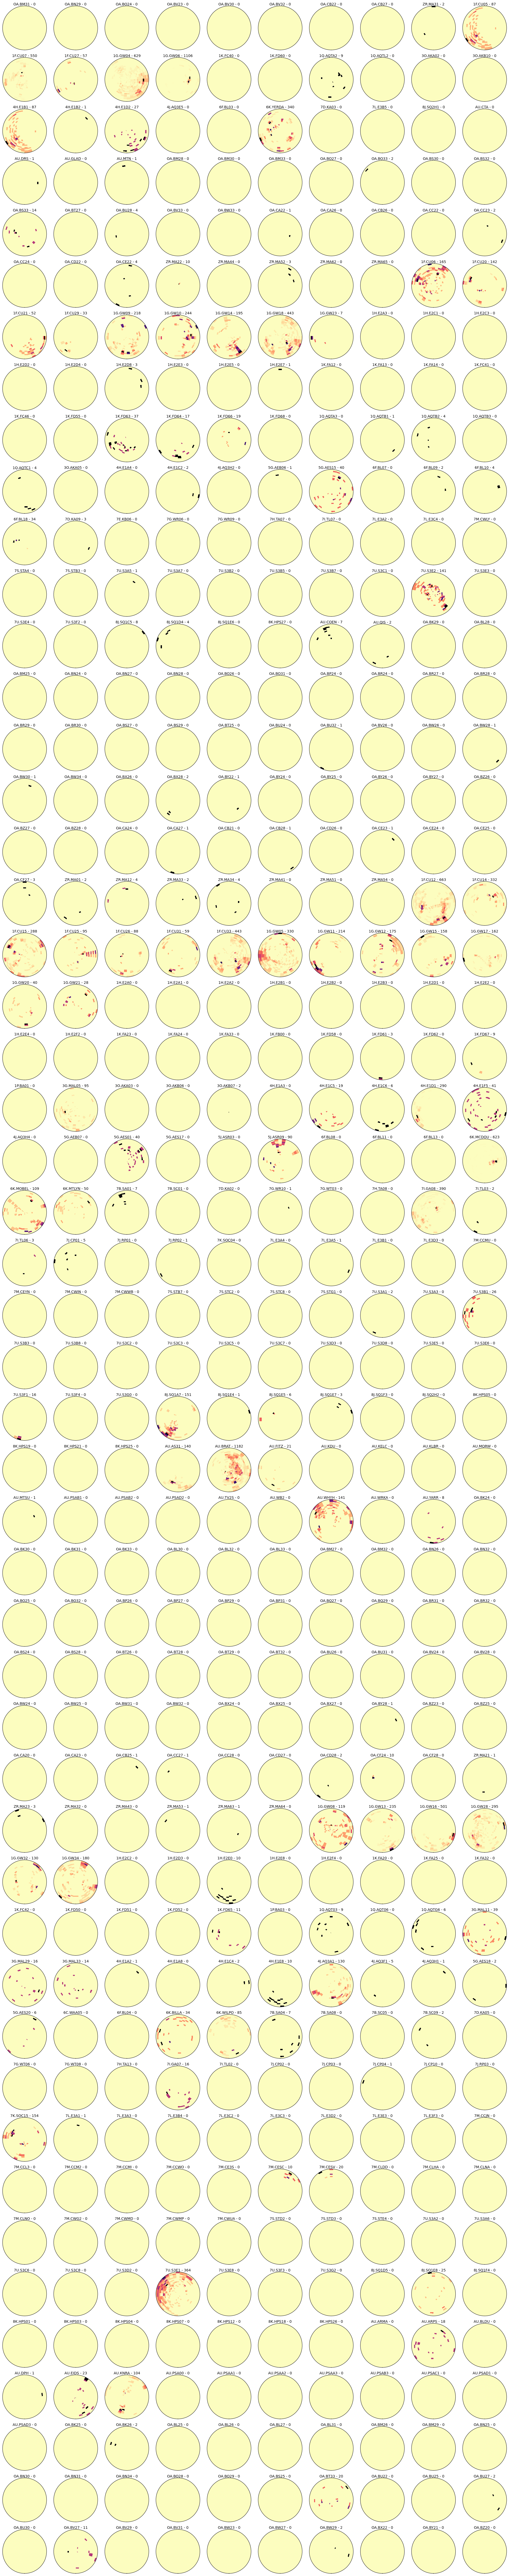

In [8]:
nrows = 50
ncols = 10
row_h = 2  # inches
col_w = 2  # inches
fig, axs = plt.subplots(
    nrows,
    ncols,
    subplot_kw=dict(projection="polar"),
    figsize=(ncols * col_w, nrows * row_h),
    tight_layout=True,
)
for ax, (i, s) in zip(axs.flatten(), seismics.iterrows()):
    # plot
    ax.grid(False)
    ax.pcolormesh(A, R, s.histograms.T, cmap="magma_r")
    ax.text(
        0.5,
        1,
        f"{i} - {int(s.borehole_count)}",
        transform=ax.transAxes,
        ha="center",
        va="bottom",
    )

    # hack to get the axes and image the right way around
    ax.set_theta_zero_location("S")
    ax.set_theta_direction(-1)
    # ax.set_xticklabels(['180°', '225°', '270°', '315°', '0°', '45°', '90°', '135°'])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

Map number of boreholes within allowed distance

/Users/u1138256/miniconda3/envs/aussedthick/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Seismic stations with 0 borehole within 27.75km')

/Users/u1138256/miniconda3/envs/aussedthick/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/u1138256/miniconda3/envs/aussedthick/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


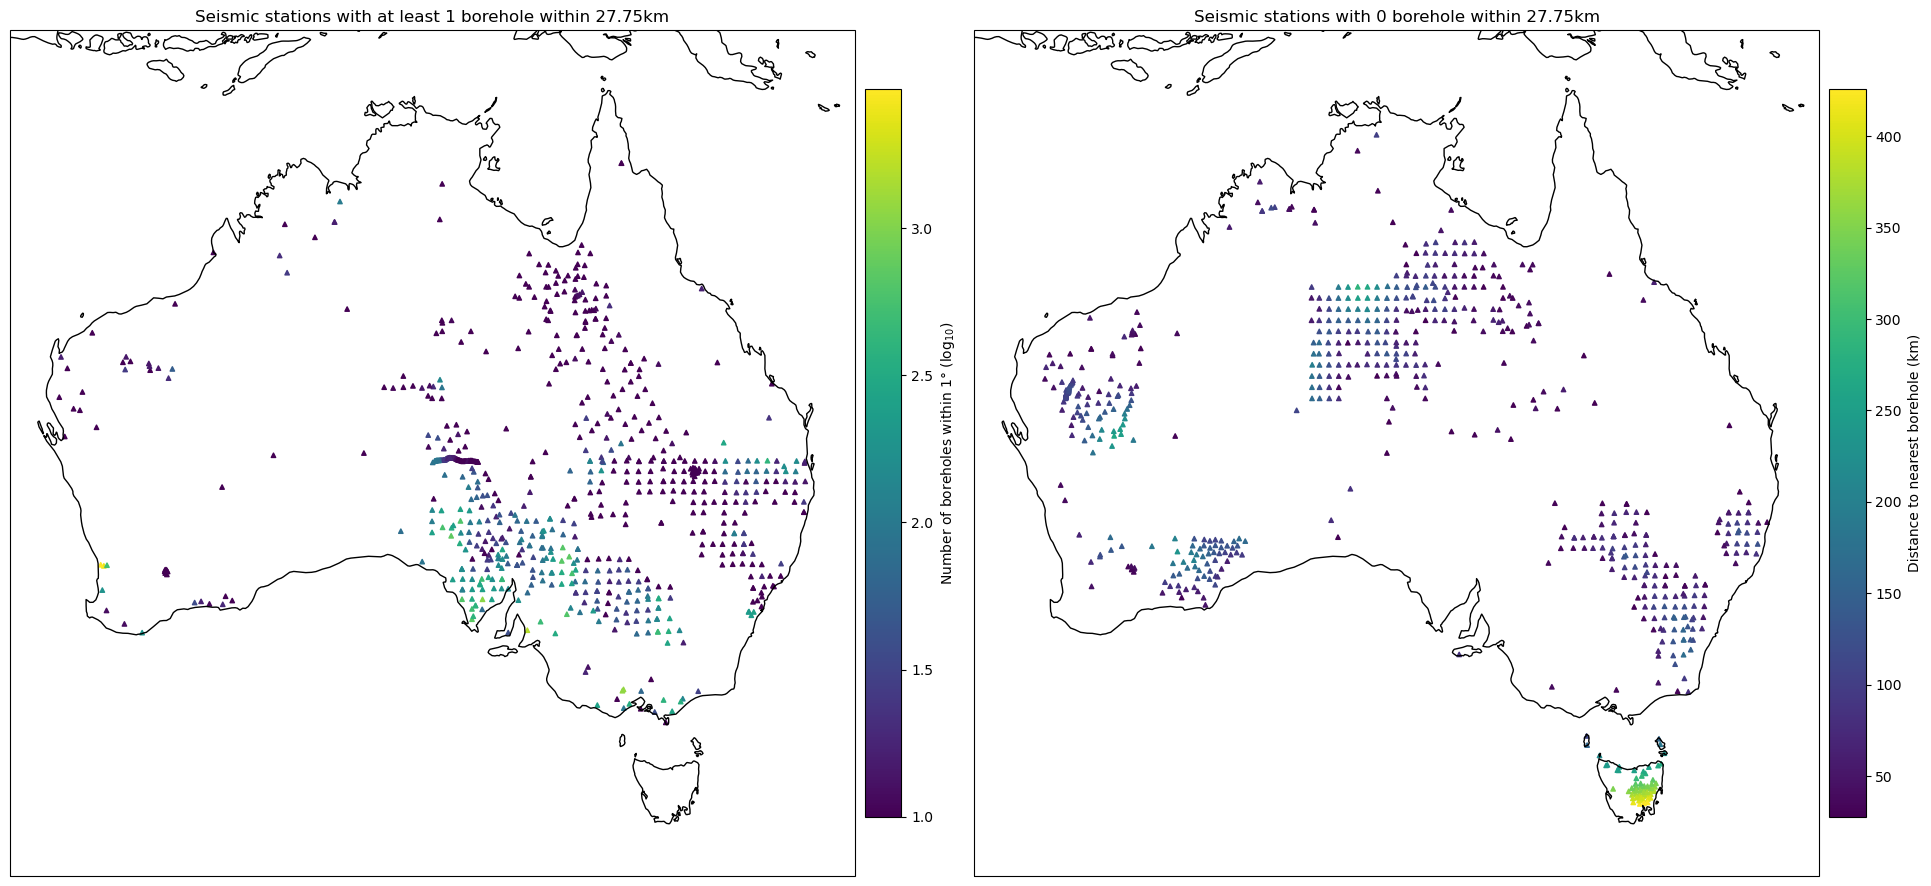

In [9]:
fig, axs = plt.subplots(
    1,
    2,
    subplot_kw=dict(projection=ccrs.Robinson(central_longitude=133)),
    figsize=(20, 10),
    tight_layout=True,
)
for ax in axs:
    ax.set_extent([112, 155, -46, -8], ccrs.PlateCarree())
    ax.coastlines()

ax = axs[0]
vmin = 1
vmax = np.log10(seismics.borehole_count).max()
ax.scatter(
    seismics.geometry.x[seismics.borehole_count > vmin],
    seismics.geometry.y[seismics.borehole_count > vmin],
    c=np.log10(seismics.borehole_count[seismics.borehole_count > vmin]),
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    transform=ccrs.PlateCarree(),
    s=10,
    marker="^",
)
fig.colorbar(
    cm.ScalarMappable(norm=Normalize(vmin, vmax), cmap="viridis"),
    ax=ax,
    label="Number of boreholes within 1° ($\log_{10}$)",
    shrink=0.75,
    pad=0.01,
)
ax.set_title(f"Seismic stations with at least 1 borehole within {max_dist}km")

ax = axs[1]
vmin = max_dist
vmax = seismics.closest_borehole_distance.max()
ax.scatter(
    seismics.geometry.x[seismics.borehole_count == 0],
    seismics.geometry.y[seismics.borehole_count == 0],
    c=seismics.closest_borehole_distance[seismics.borehole_count == 0],
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    transform=ccrs.PlateCarree(),
    s=10,
    marker="^",
)
fig.colorbar(
    cm.ScalarMappable(norm=Normalize(vmin, vmax), cmap="viridis"),
    ax=ax,
    label="Distance to nearest borehole (km)",
    shrink=0.75,
    pad=0.01,
)
ax.set_title(f"Seismic stations with 0 borehole within {max_dist}km")

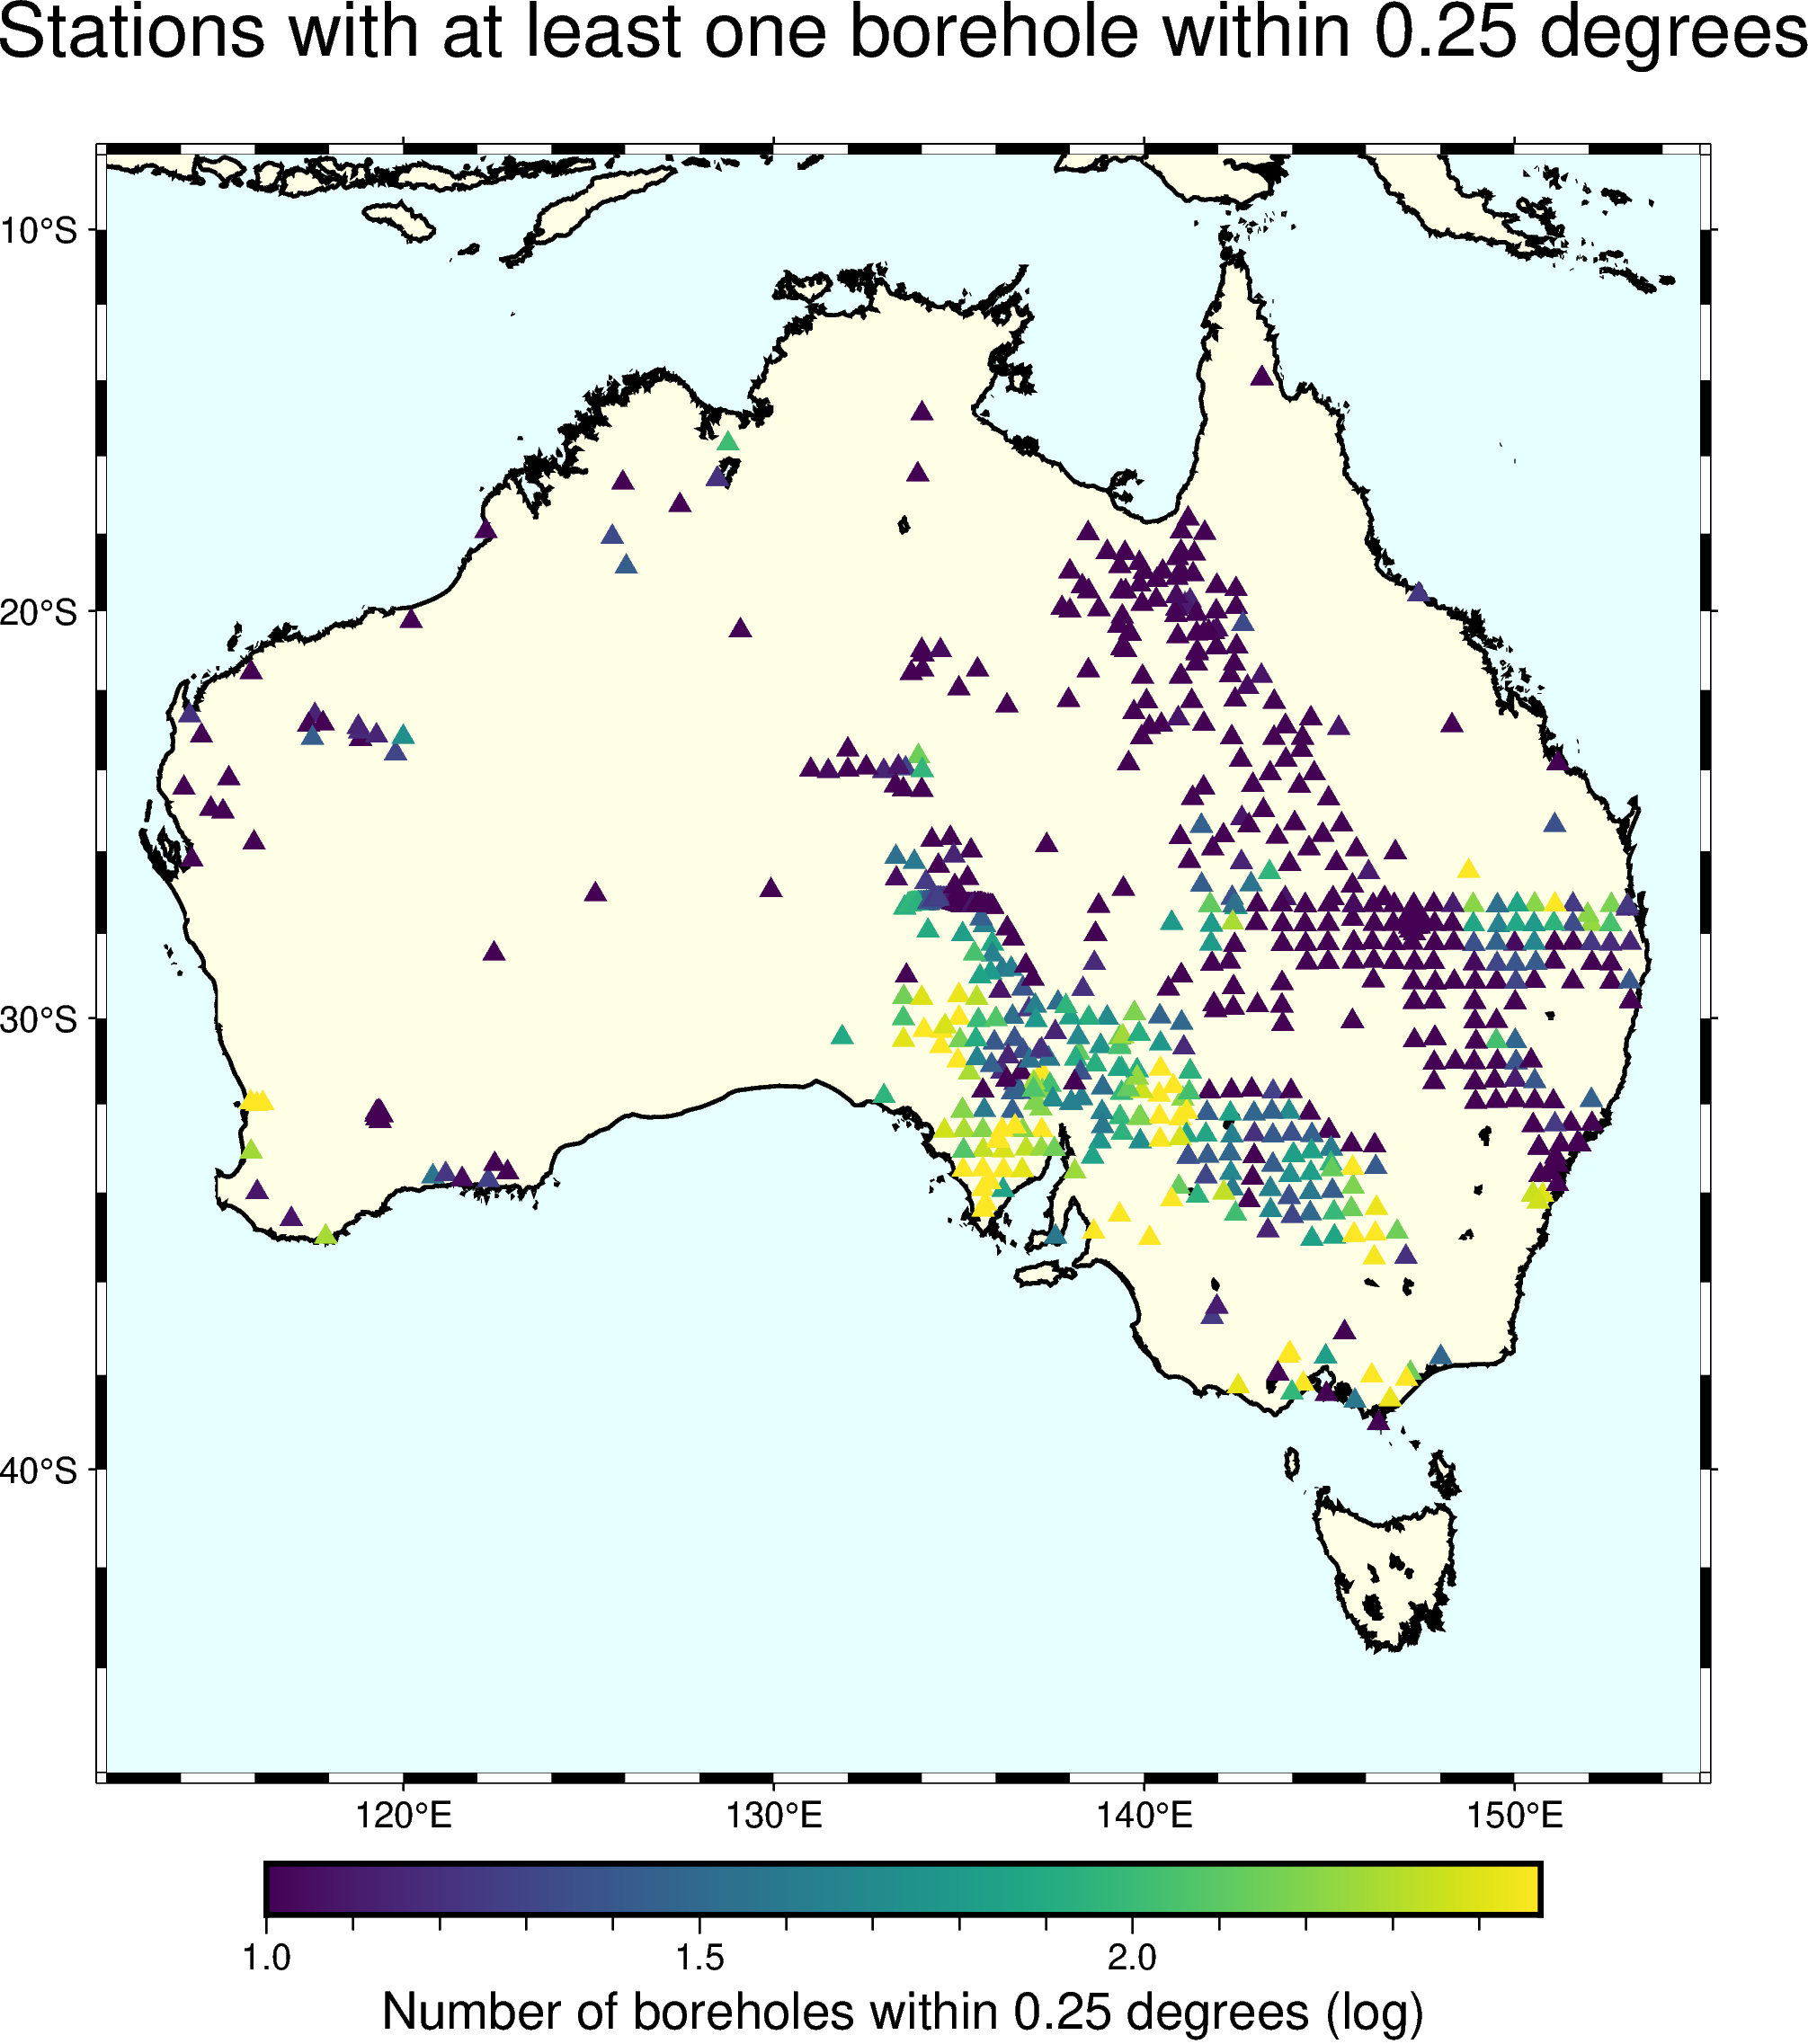

In [10]:
vmin = 1
vmax = np.log10(seismics.borehole_count).max() - 1

fig, region, projection = australia_basemap(basins=False, frame=["af", "+tStations with at least one borehole within 0.25 degrees"])
pygmt.makecpt(
    cmap="viridis",
    series=[vmin, vmax],
    background="o",
)
fig.plot(
    region=region,
    projection=projection,
    x=seismics.geometry.x[seismics.borehole_count > vmin],
    y=seismics.geometry.y[seismics.borehole_count > vmin],
    style=f"tc",
    fill=np.log10(seismics.borehole_count[seismics.borehole_count > vmin]),
    cmap=True,
    size=np.full_like(seismics.geometry.x[seismics.borehole_count > vmin], 0.25),
)
fig.colorbar(
    region=region,
    projection=projection,
    frame=['af+l"Number of boreholes within 0.25 degrees (log)"'],
    position="JBC",
)
fig.show()

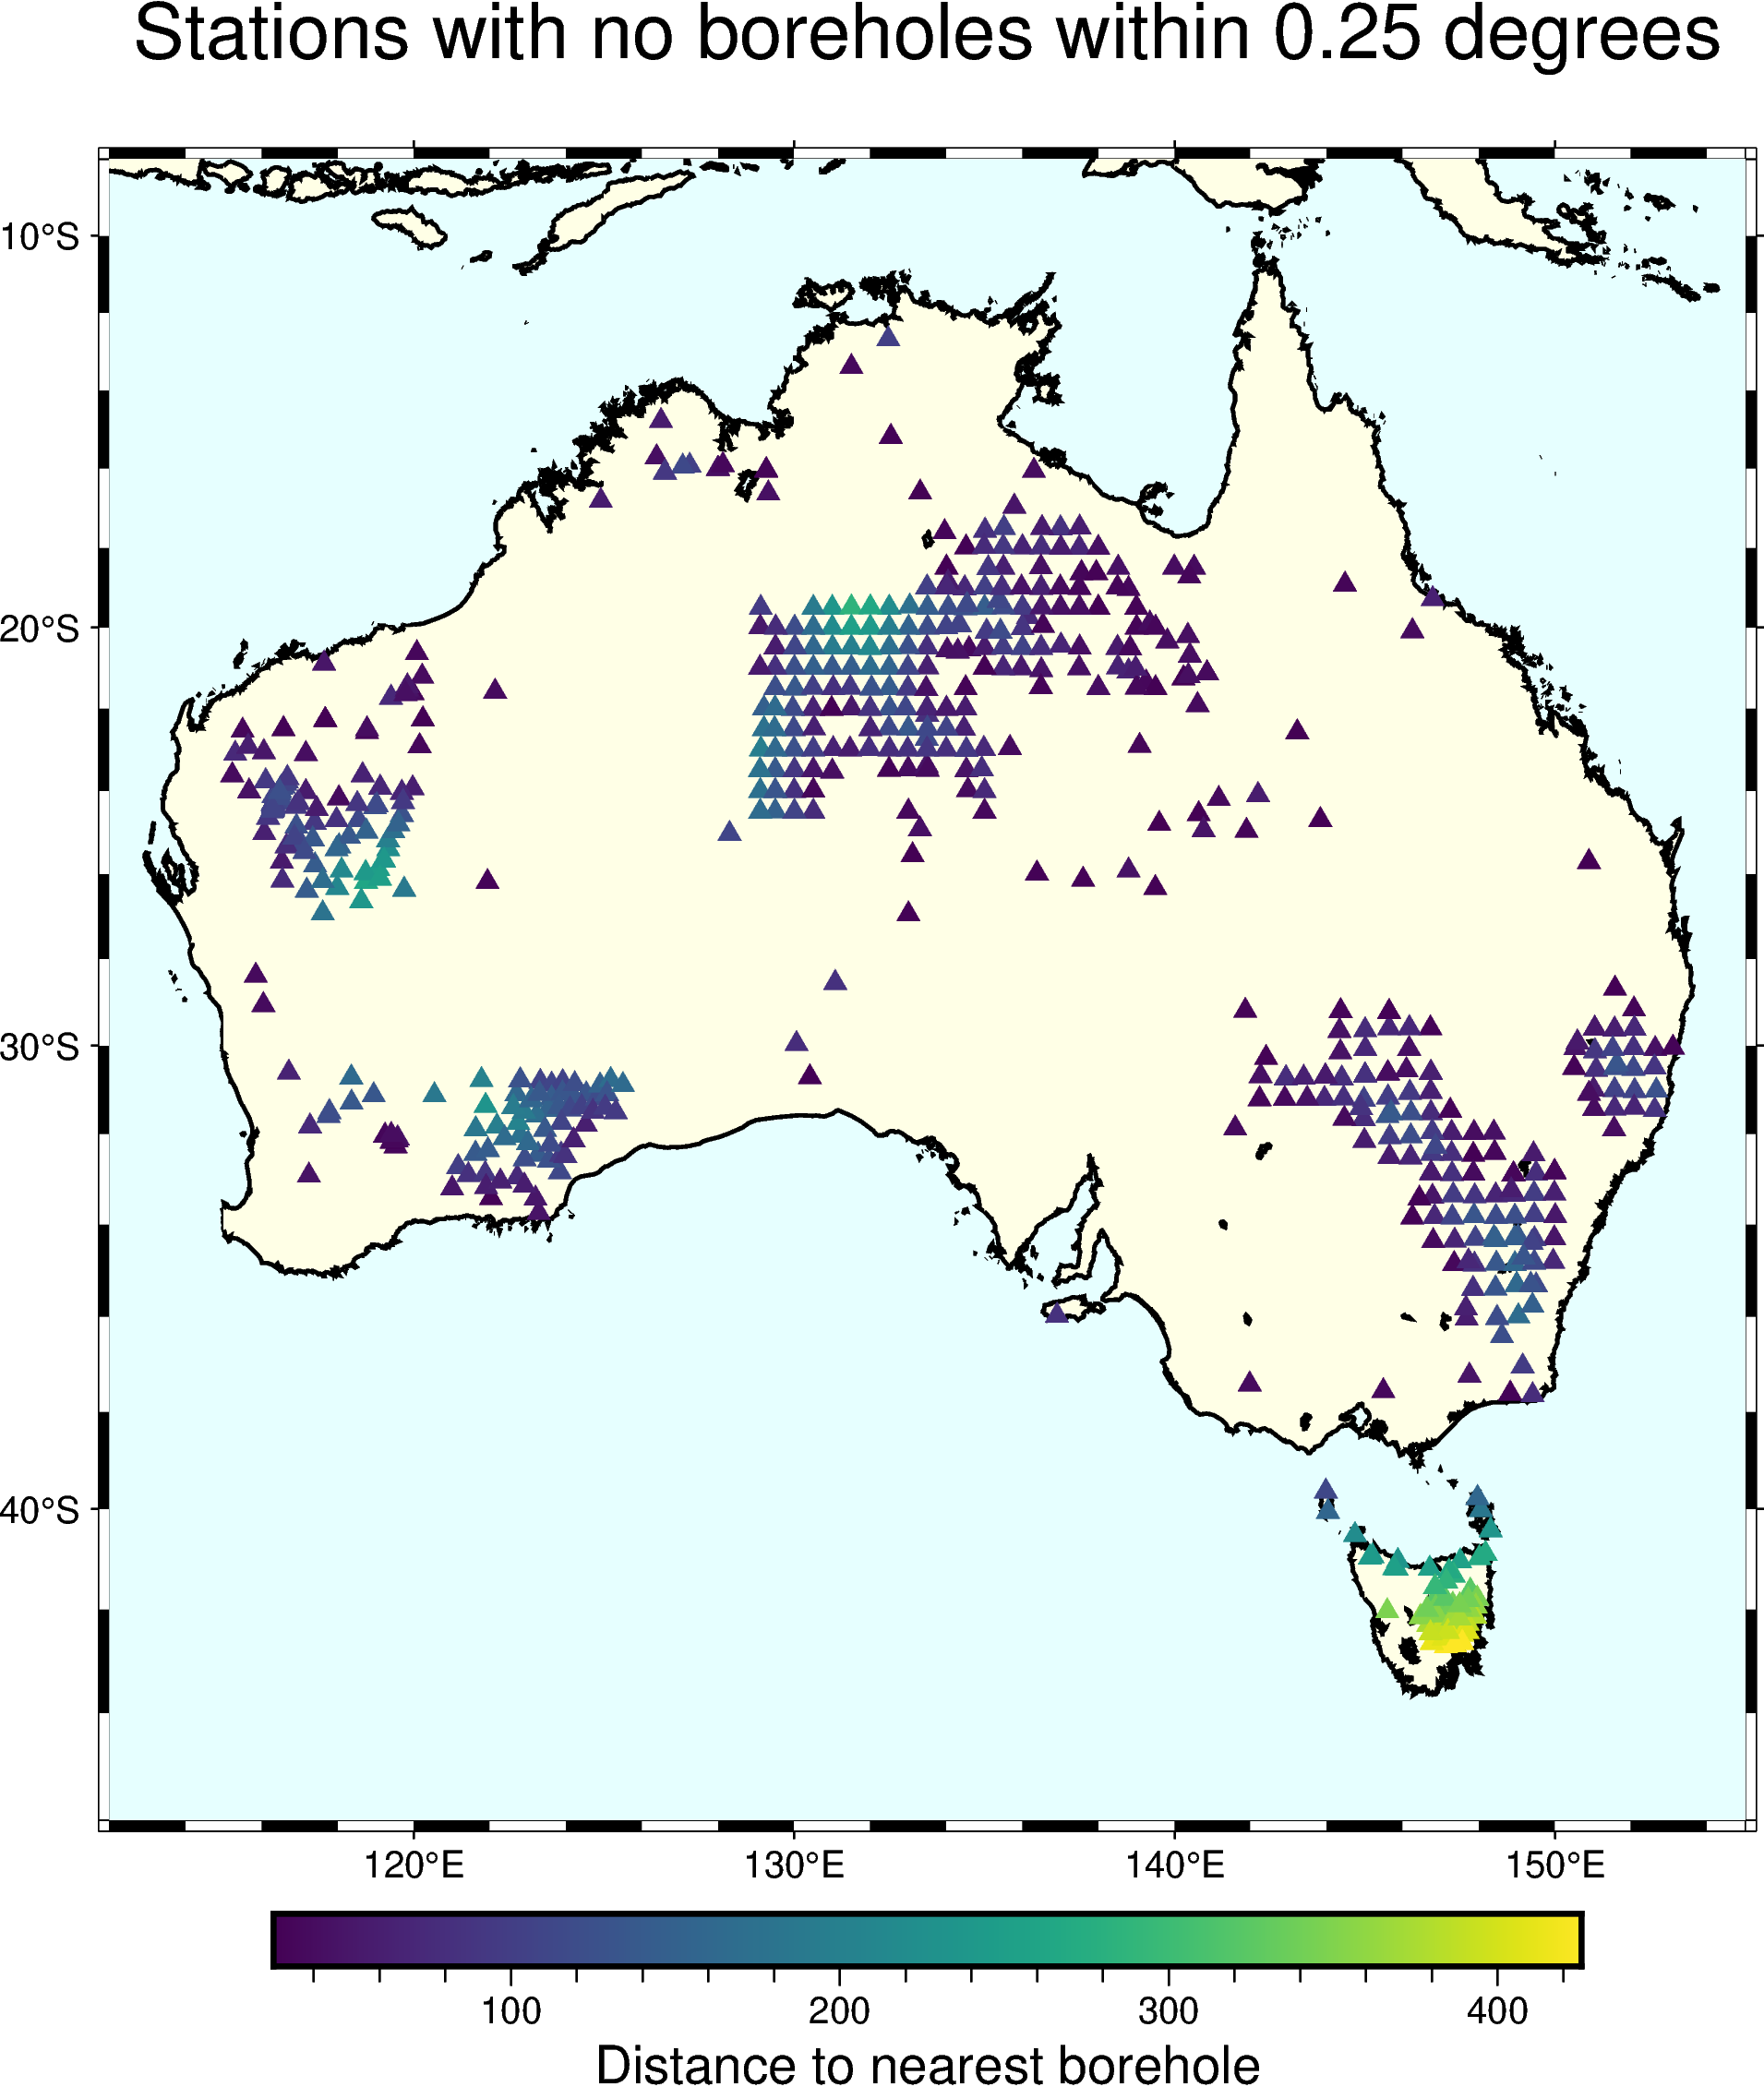

In [11]:
vmin = max_dist
vmax = seismics.closest_borehole_distance.max()
fig, region, projection = australia_basemap(basins=False, frame=["af", "+tStations with no boreholes within 0.25 degrees"])
pygmt.makecpt(
    cmap="viridis",
    series=[vmin, vmax],
    background="o",
)
fig.plot(
    region=region,
    projection=projection,
    x=seismics.geometry.x[seismics.borehole_count == 0],
    y=seismics.geometry.y[seismics.borehole_count == 0],
    style=f"tc",
    fill=seismics.closest_borehole_distance[seismics.borehole_count == 0],
    cmap=True,
    size=np.full_like(seismics.geometry.x[seismics.borehole_count == 0], 0.25),
)
fig.colorbar(
    region=region,
    projection=projection,
    frame=['af+l"Distance to nearest borehole"'],
    position="JBC",
)
fig.show()

Estimate depth at each seismic station

In [12]:
class DepthEstimators:
    def __init__(self, boreholes, max_dist=111):
        """
        boreholes - GeoDataBase with locations of boreholes with depth estimates
        max_dist - float maximum distance (km) to search for boreholes from seismic station
        """
        self.boreholes = boreholes
        self.bh_array = np.array([boreholes.geometry.x, boreholes.geometry.y]).T
        self.max_dist = max_dist

    def __call__(self, station, method=None):
        if method is None:
            method = self.max_depth
        if not isinstance(station, Point):
            raise TypeError("Input station should be of type shapely.geometry.point.Point")
        return method(station)

    def max_depth(self, station):
        return self._find_boreholes(station).BASEMENT_DEPTH.max()

    def mean_depth(self, station):
        return self._find_boreholes(station).BASEMENT_DEPTH.mean()

    def idw_mean_depth(self, station):
        bhs, dists = self._find_boreholes(station, return_dists=True)
        weights = 1 / dists
        return (bhs.BASEMENT_DEPTH * weights).sum() / weights.sum()

    def closest_depth(self, station):
        bhs, dists = self._find_boreholes(station, return_dists=True)
        return bhs.iloc[np.argmin(dists)].BASEMENT_DEPTH

    def _find_distances(self, station):
        inv = geo.inverse([station.x, station.y], self.bh_array)
        inv[:, 0] /= 1000  # m -> km
        return inv[:, 0]

    def _find_boreholes(self, station, return_dists=False):
        dists = self._find_distances(station)
        inds = np.argwhere(dists <= self.max_dist).flatten()

        if return_dists:
            if inds.size == 0:
                return self._return_empty_gdb(), np.array([np.nan])
            return self.boreholes.iloc[inds], dists[inds]

        return self._return_empty_gdb() if inds.size == 0 else self.boreholes.iloc[inds]

    def _return_empty_gdb(self):
        return gpd.GeoDataFrame(np.nan, index=[0], columns=boreholes.columns)

In [13]:
estimator = DepthEstimators(boreholes, max_dist=max_dist)


def job(method):
    return np.array(
        [estimator(station, method=method) for station in tqdm(seismics.geometry)]
    )


estimates = np.array(
    Parallel(n_jobs=4)(
        delayed(job)(method)
        for method in [
            estimator.max_depth,
            estimator.mean_depth,
            estimator.idw_mean_depth,
            estimator.closest_depth,
        ]
    )
)

100%|██████████| 1457/1457 [01:16<00:00, 19.11it/s]


In [14]:
seismics["MAX_DEPTH"] = estimates[0]
seismics["MEAN_DEPTH"] = estimates[1]
seismics["IDW_MEAN_DEPTH"] = estimates[2]
seismics["CLOSEST_DEPTH"] = estimates[3]
depth_estimates = seismics[
    ["geometry", "MAX_DEPTH", "MEAN_DEPTH", "IDW_MEAN_DEPTH", "CLOSEST_DEPTH"]
]

Map the depth estimates


/Users/u1138256/Documents/aussedthick/AusSedThick/aussedthickrf/utils.py:224: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  key_basins.sort_values(by="period_age", ascending=False)
/Users/u1138256/miniconda3/envs/aussedthick/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/u1138256/Documents/aussedthick/AusSedThick/aussedthickrf/utils.py:224: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  key_basins.sort_values(by="period_age", ascending=False)
/Users/u1138256/miniconda3/envs/aussedthick/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/u1138

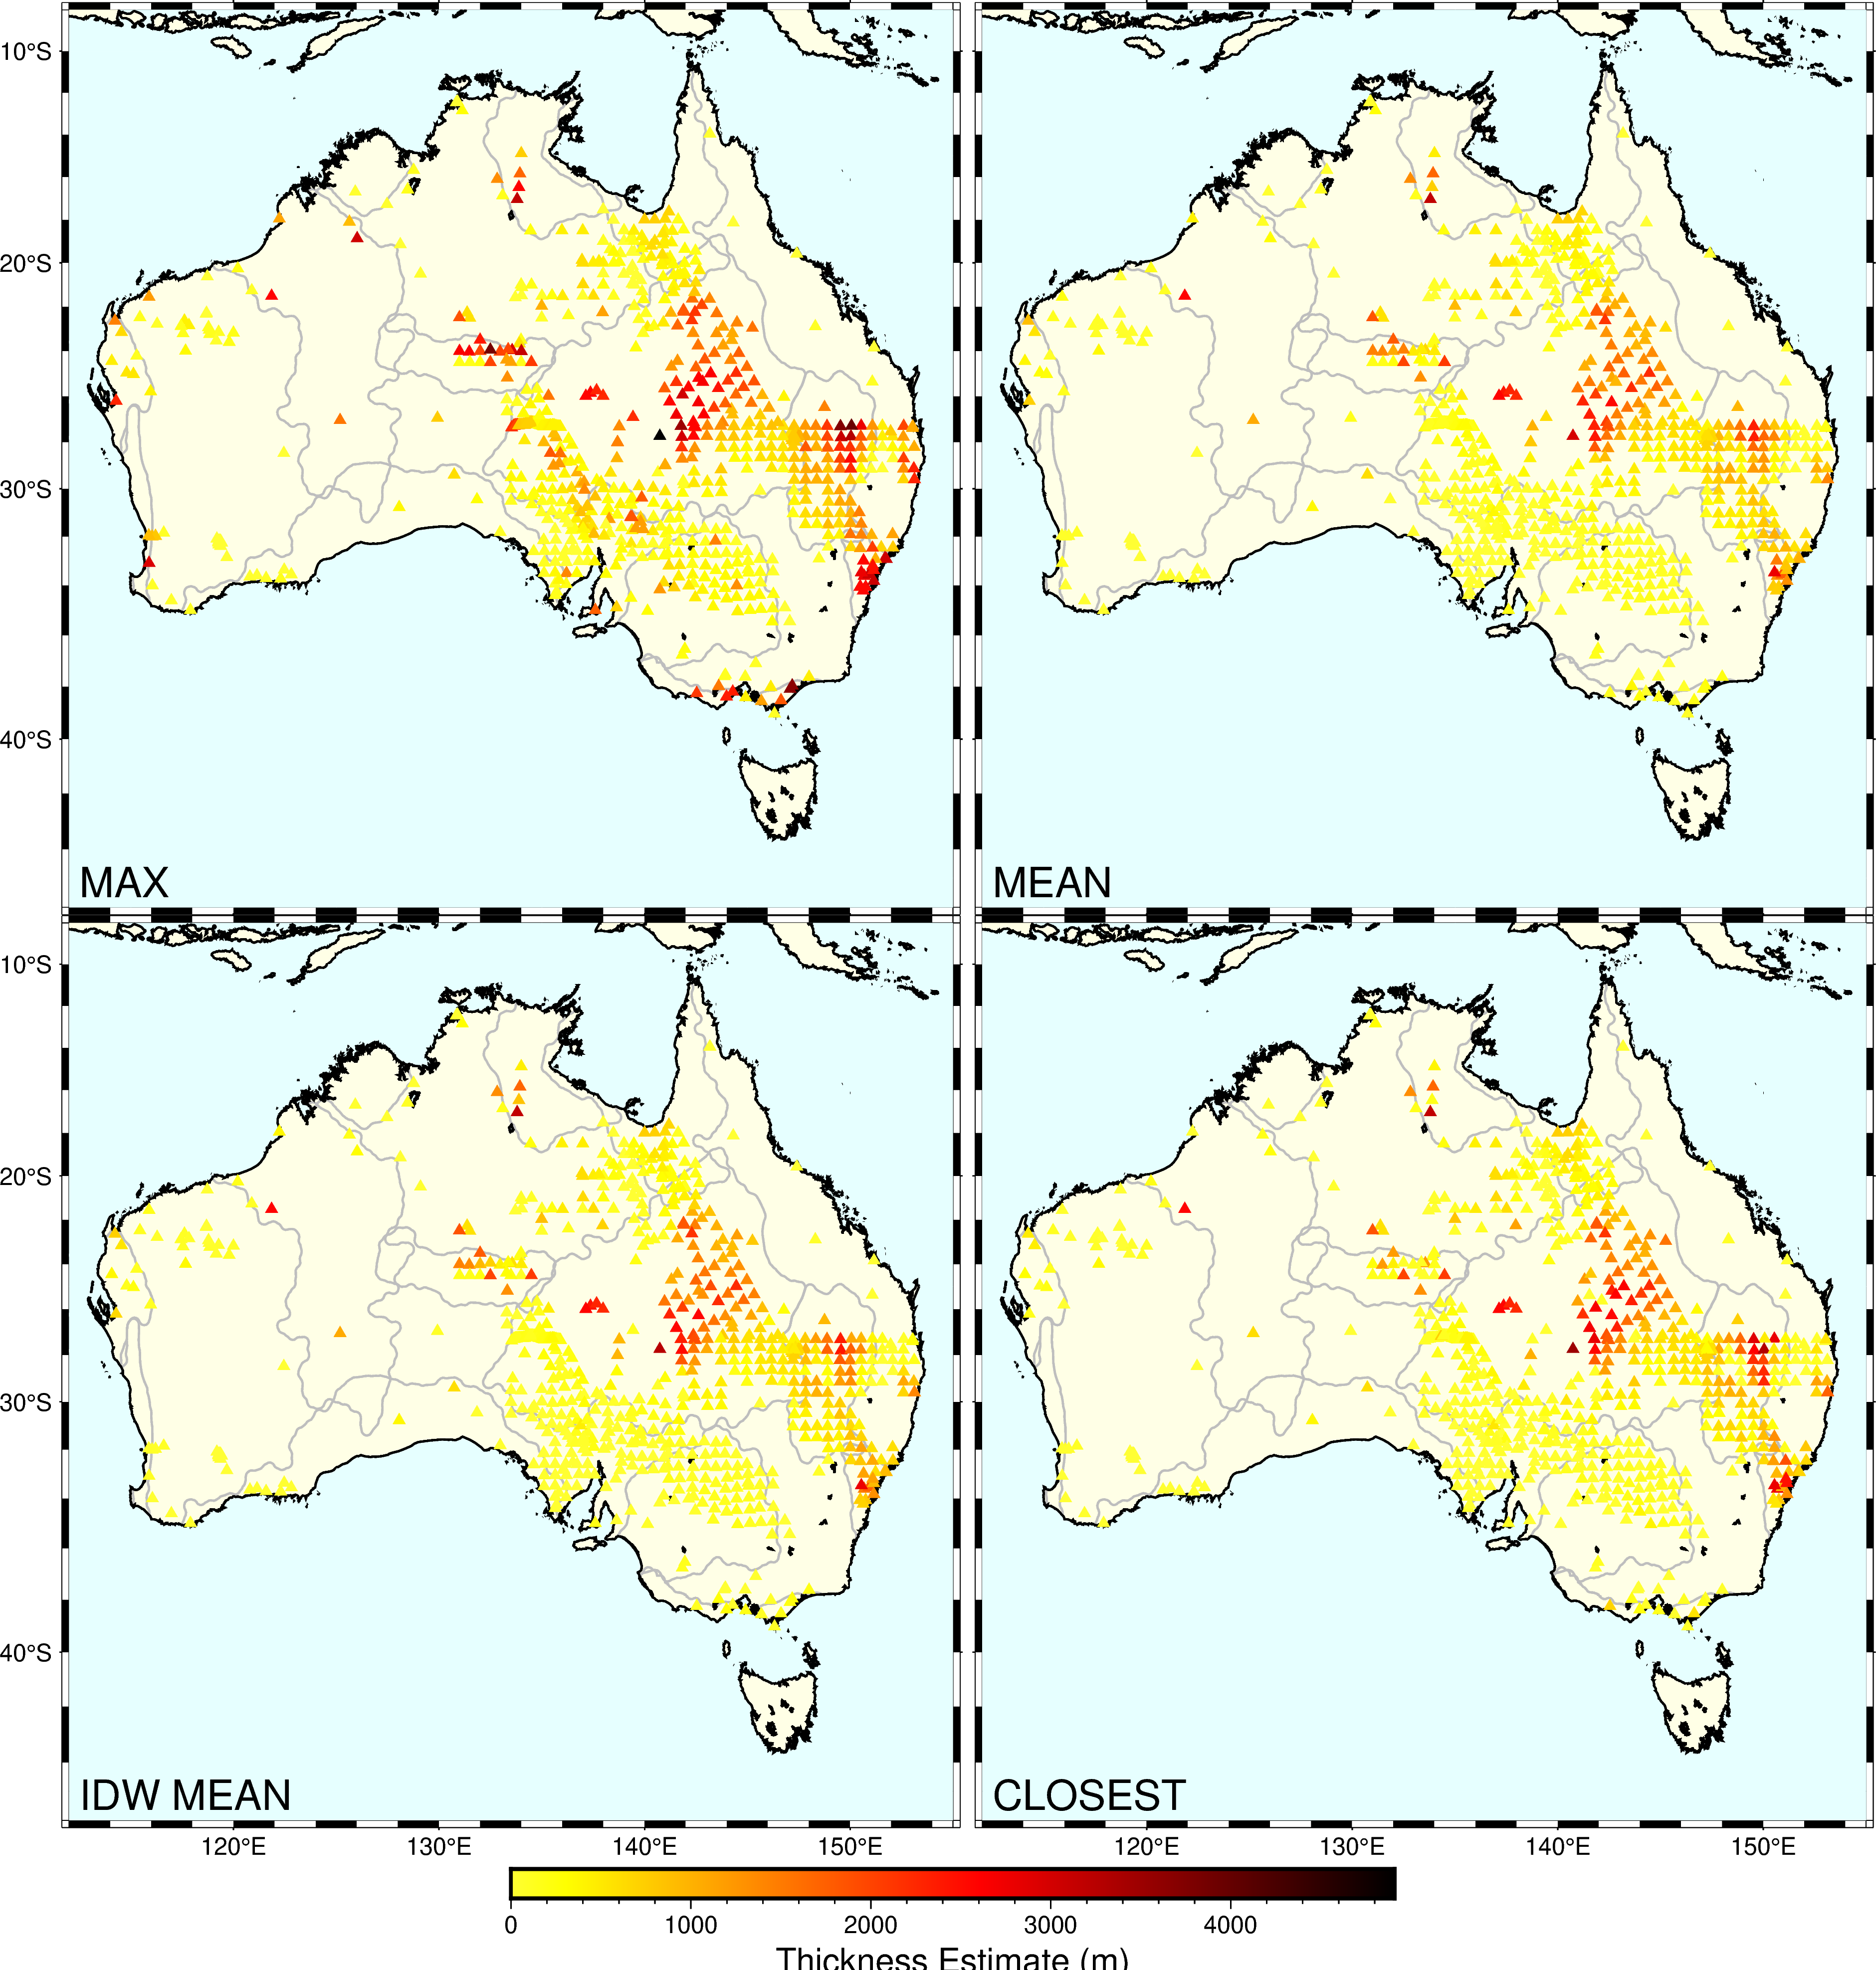

In [26]:
fig = pygmt.Figure()
vmin = (depth_estimates.loc[:, depth_estimates.columns != "geometry"].min()).min()
vmax = (depth_estimates.loc[:, depth_estimates.columns != "geometry"].max()).max()
pygmt.makecpt(cmap="hot", truncate=[0, 0.8], series=[vmin, vmax, 1],background="o", reverse=True)

with fig.subplot(nrows=2, ncols=2, figsize=("30c", "30c")):
    for i in range(2):
        for j in range(2):
            index = i * 2 + j
            depth = depth_estimates.loc[:, depth_estimates.columns != "geometry"].columns[index]
            if index == 0:
                _frame = ["Wsne"]
            elif index == 1:
                _frame = ["wsne"]
            elif index == 2:
                _frame = ["WSne"]
            elif index == 3:
                _frame = ["wSne"]
            with fig.set_panel(panel=index):
                _, _reg, _proj = australia_basemap(fig=fig, frame=_frame + ["xaf", "yaf"])
                fig.text(text=" ".join(depth.split("_")[:-1]), position="BL", font="20p", offset="5p", region=_reg, projection=_proj)

                fig.plot(
                    region=_reg,
                    projection=_proj,
                    x=(depth_estimates.dropna(axis=0, subset=depth)).geometry.x,
                    y=(depth_estimates.dropna(axis=0, subset=depth)).geometry.y,
                    style=f"tc",
                    fill=(depth_estimates.dropna(axis=0, subset=depth))[depth],
                    cmap=True,
                    size=np.full_like((depth_estimates.dropna(axis=0, subset=depth)).geometry.x, 0.25),
                )
fig.colorbar(position="JBC+w15c/0.5c+h", frame="+lThickness Estimate (m)")
fig.show()